In [1]:
# !pip install --upgrade sympy
# !pip install -U transformers
# !pip install -U datasets
# !pip install tensorboard
# !pip install sentencepiece
# !pip install accelerate
# !pip install evaluate
# !pip install rouge_score


In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

import glob
import pprint

pp = pprint.PrettyPrinter()

In [3]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
def summarize_text(text, model, tokenizer, max_length=512, num_beams=5):
    # Preprocess the text
    inputs = tokenizer.encode(
        "summarize: " + text,
        return_tensors='pt',
        max_length=max_length,
        truncation=True
    )

    # Generate the summary
    summary_ids = model.generate(
        inputs,
        max_length=50,
        num_beams=num_beams,
        # early_stopping=True,
    )

    # Decode and return the summary
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [5]:
for file_path in glob.glob('inference_data/*.txt'):
    file = open(file_path)
    text = file.read()
    summary = summarize_text(text, model, tokenizer)
    pp.pprint(summary)
    print('-'*75)

In [6]:
import torch
import pprint
import evaluate
import numpy as np

from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset

In [7]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split='train')
full_dataset = dataset.train_test_split(test_size=0.2, shuffle=True)
dataset_train = full_dataset['train']
dataset_valid = full_dataset['test']
dataset_train = dataset_train.select(range(1500))
dataset_valid = dataset_valid.select(range(100))

print(dataset_train)
print(dataset_valid)

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 1500
})
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 100
})


In [8]:
MODEL = 't5-base'
BATCH_SIZE = 4
NUM_PROCS = 4
EPOCHS = 10
OUT_DIR = 'results_t5base'
MAX_LENGTH = 512

In [9]:
tokenizer = T5Tokenizer.from_pretrained(MODEL)

# Function to convert text data into model inputs and targets
def preprocess_function(examples):
    inputs = [f"summarize: {article}" for article in examples['article']]
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_LENGTH,
        truncation=True,
        padding='max_length'
    )

    # Set up the tokenizer for targets
    targets = [summary for summary in examples['highlights']]
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=MAX_LENGTH,
            truncation=True,
            padding='max_length'
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the function to the whole dataset
tokenized_train = dataset_train.map(
    preprocess_function,
    batched=True,
    num_proc=NUM_PROCS
)
tokenized_valid = dataset_valid.map(
    preprocess_function,
    batched=True,
    num_proc=NUM_PROCS
)

Map (num_proc=4):   0%|          | 0/1500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [10]:
model = T5ForConditionalGeneration.from_pretrained(MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

222,903,552 total parameters.
222,903,552 training parameters.


In [11]:

from sklearn.metrics import accuracy_score
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions[0], eval_pred.label_ids

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        rouge_types=[
            'rouge1',
            'rouge2',
            'rougeL'
        ]
    )

    accuracy = accuracy_score(decoded_labels, decoded_preds)
    result["accuracy"] = accuracy

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [12]:
def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak.
    This is a workaround to avoid storing too many tensors that are not needed.
    """
    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids, labels

In [13]:
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=OUT_DIR,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=200,
    save_strategy='epoch',
    save_total_limit=2,
    report_to='tensorboard',
    learning_rate=0.0001,
    dataloader_num_workers=4
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics
)

history = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Accuracy,Gen Len
200,0.249800,0.242851,0.618400,0.364800,0.582400,0.000000,74.010000
400,0.251200,0.217903,0.631700,0.371500,0.590400,0.010000,74.900000
600,0.232600,0.217080,0.632700,0.379300,0.595300,0.010000,74.910000
800,0.168700,0.218493,0.627300,0.373200,0.589500,0.010000,74.920000
1000,0.189100,0.218877,0.624300,0.368400,0.587800,0.010000,74.930000
1200,0.154500,0.223167,0.627300,0.370100,0.589400,0.010000,74.940000
1400,0.166800,0.223689,0.625300,0.366700,0.586800,0.010000,74.930000
1600,0.160700,0.227837,0.624000,0.365700,0.585400,0.010000,74.930000
1800,0.168700,0.229066,0.625000,0.366500,0.586100,0.010000,74.930000
2000,0.126000,0.233892,0.625300,0.370600,0.588400,0.010000,74.930000


In [14]:
import torch
torch.cuda.empty_cache()


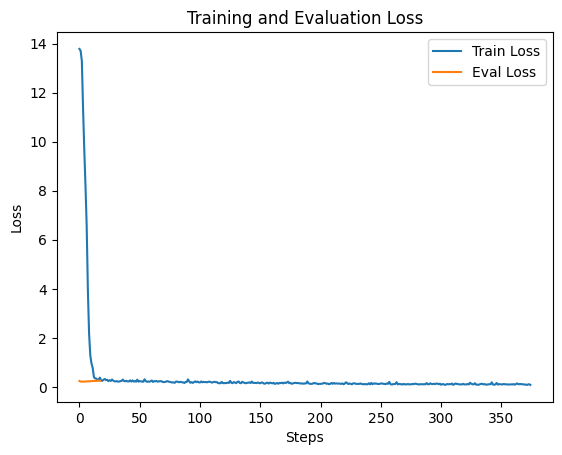

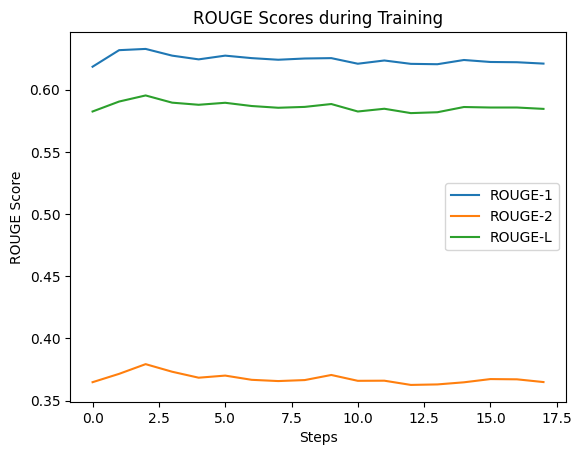

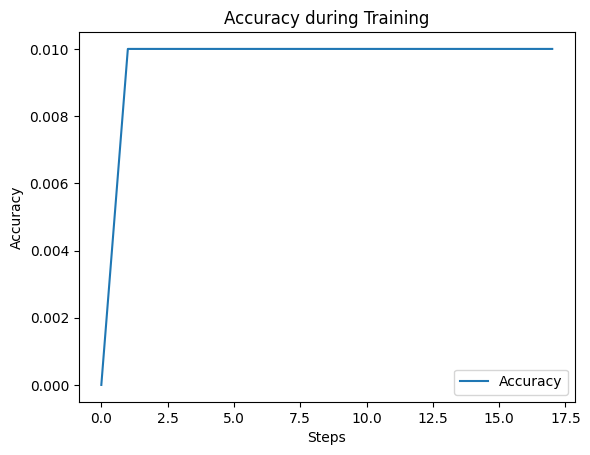

In [15]:
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt

# Access the log history for metrics like loss, accuracy, and ROUGE
log_history = trainer.state.log_history

# Extract specific metrics
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
accuracy = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]
rouge1 = [entry['eval_rouge1'] for entry in log_history if 'eval_rouge1' in entry]
rouge2 = [entry['eval_rouge2'] for entry in log_history if 'eval_rouge2' in entry]
rougeL = [entry['eval_rougeL'] for entry in log_history if 'eval_rougeL' in entry]

# Now you can plot these metrics using matplotlib
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

plt.plot(rouge1, label='ROUGE-1')
plt.plot(rouge2, label='ROUGE-2')
plt.plot(rougeL, label='ROUGE-L')
plt.xlabel('Steps')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores during Training')
plt.legend()
plt.show()

plt.plot(accuracy, label='Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()
plt.show()


In [16]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Directory to save the model and tokenizer
SAVE_DIR = 't5_model'

# Save the model
model.save_pretrained(SAVE_DIR)

# Save the tokenizer
tokenizer.save_pretrained(SAVE_DIR)

print(f"Model and tokenizer saved to {SAVE_DIR}")


Model and tokenizer saved to t5_model


In [17]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Directory where the model and tokenizer were saved
SAVE_DIR = 't5_model'

# Load the model
model2 = T5ForConditionalGeneration.from_pretrained(SAVE_DIR)

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(SAVE_DIR)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [22]:
model.save_pretrained('T5.keras')

In [23]:
model.save_pretrained('T5.h5')

In [19]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import numpy as np

# Load the tokenizer and model
MODEL = 't5-base'
# tokenizer = T5Tokenizer.from_pretrained(MODEL)
# model = T5ForConditionalGeneration.from_pretrained(MODEL).to("cuda" if torch.cuda.is_available() else "cpu")

def sample_from_logits(logits, temperature=1.0, top_k=50):
    """
    Sample a token from the logits using temperature and top-k sampling.
    """
    logits = logits / temperature  # Apply temperature scaling
    logits = logits.cpu().detach().numpy()  # Convert logits to numpy array

    # Apply top-k sampling
    top_k_indices = np.argsort(logits)[-top_k:]  # Get top-k indices
    top_k_logits = logits[top_k_indices]  # Get top-k logits
    top_k_probs = np.exp(top_k_logits) / np.sum(np.exp(top_k_logits))  # Compute probabilities
    selected_token = np.random.choice(top_k_indices, p=top_k_probs)  # Sample a token

    return selected_token

def generate_summary(input_text, tokenizer, model2, max_input_len=512, max_output_len=128, temperature=1.0, top_k=50):
    """
    Generate a summary using the T5 model with sampling.
    """
    # Step 1: Tokenize the input text
    input_ids = tokenizer.encode(
        input_text,
        max_length=max_input_len,
        truncation=True,
        return_tensors='pt',
        padding='max_length'
    ).to(model.device)

    # Step 2: Generate predictions
    output = model.generate(
        input_ids=input_ids,
        max_length=max_output_len,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        num_return_sequences=1
    )

    # Step 3: Decode the generated output
    generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_summary

# Example usage
input_text = '''Years ago, my favorite cracker was Keebler Club. One day, I saw the multi-grain version and thought I’d try it,
    especially since I enjoy whole-grain breads and am trying to lower cholesterol. I couldn’t believe the multi-grain
    version actually tastes better than the original! I bought several boxes of these crackers and always keep some on hand.
    I use them for Asian tuna salad, with Inglehoffer sweet honey mustard, or as spreads for soups. They are tasty crackers.
'''

summary = generate_summary(input_text, tokenizer, model, max_input_len=400, max_output_len=100, temperature=0.7, top_k=50)
print("Generated Summary:", summary)


Generated Summary: The – maybe just the taste! I also bought some I have in my pantry. I love whole-grain, though they can be hard to find! I have several boxes of these and always have some on hand..
